# Generate Molecular Structure Descriptors for a Zeolite

Nanoporous materials such as zeolites have pore dimensions similar to that of individual molecules and are used widely in industry as adsorbents, catalysts and chemical separation membranes. The nanoscale cavities in these materials serve as shape and size selective sites facilitating chemical reactions as well as storage, while the channels serve as molecular sieves that can be used for gas separations replacing energetically less efficient distillation processes. 

This notebook presents an approach outlined in [1] for generating computationally efficient digital representations of the molecular structure of nanoporous materials that are then used to compute a number of geometric and statistical descriptors for pore structures. The described methods are capable of identifying and labeling the transport relevant accessible regions in the porous crystals for any user-defined non-spherical atomic-scale morphology. These descriptors can be used as predictors for transport properties.

The notebooks includes the following steps,

 1. [load a cif file with the Zeolite structure](#Load-Structure-of-Interest)
 1. [generate a voxelized representation of the molecular structure](#Generate-Voxelized-Representation-of-the-Pore-Structure)
 1. [compute conventional pore metrics](#Compute-Conventional-Pore-Metrics---PLD-and-LCD)
 1. [compute transport channels through the pore structure](#Geometric-and-Statistical-analysis-of-diffusion-pathways)

![image of zeolite](./DDR_structure.gif)

The image shows the 277x240x813 voxelized molecular structure of the unit cell of a 3D bulk zeolite (namely DDR) at a grid resolution of 0.1 Å. Red voxels correspond to oxygen and orange voxels correspond to silicon atoms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../../../")

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import ase
import time
import glob
import numpy as np
import pandas as pd
import ase.io as aio
import scipy.io as sio
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose
from collections import defaultdict, OrderedDict

import pymks.atommks.porosity as pore
from pymks.atommks.helpers import write2vtk
from pymks.atommks.helpers import save_file, load_file
from pymks.atommks.grid_generator import generate_grids

from pymks.atommks.canonical_paths import calc_path_distance, calc_path_distances_matrix, calc_canonical_paths

np.set_printoptions(precision=1)

## Load the Zeolite Structure

In the following steps we use the `get_structure_data` function to load the ASE atom object and the corresponding atomic radii. The `get_radius` function loads the atom radii from the [Cambridge Crystlaographic Structural Database][cam]. This is used to give each atom a spherical volume in the voxelized representation of the structure.

[cam]: https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/Elemental_Radii.xlsx

In [4]:
def get_radius(atom_id, radius_type="vdw"):
    """
    Get the radius of the atom
    
    Args:
      atom_id: element symbol
      radius_type = "vdw" for Van der Waals or "cov" for Covalent
      
    Returns:
      the atomic radius
      
    >>> get_radius('Na')
    2.27
    """
    xl = pd.ExcelFile("Elemental_Radii.xlsx")
    df = xl.parse(sheet_name=0, header = 2, index_col=1)
    
    if radius_type is "cov":
        key = 6
    elif radius_type is "vdw":
        key = 7
    else:
        raise ValueError("radius_type not supported")
    if atom_id in df.index:
        return df.loc[atom_id][key]
    else:
        raise ValueError("Elemental symbol not found")

def get_structure_data(cif_file_path, resize_unit_cell=1):
    """
    Get the ASE atom object (a molecule in many cases) and corresponding
    radii for each atom in the molecule
    
    Args:
      cif_file_path: path to the CIF file
      resize_unit_cell: allows a resize of the atom object
      
    Returns:
      a tuple of the ASE atom object and dictionary of atom radii
    
    >>> get_structure_data('iza_zeolites/DDR.cif')[0].get_cell_lengths_and_angles()
    array([ 27.59,  27.59,  81.5 ,  90.  ,  90.  , 120.  ])
    
    """
    ase_atom = aio.read(cif_file_path).repeat(resize_unit_cell if hasattr(resize_unit_cell, "__len__") else [resize_unit_cell] * 3)
    atom_ids = sorted(np.unique(ase_atom.get_chemical_symbols()))
    return (
        ase_atom,
        {idx:get_radius(idx) for idx in atom_ids}
    )

def generate_tubular_paths(data, size=5):
    
    import scipy
    
    
    data = np.pad(
            data,
            [(size, size)]*3,
            'constant',
            constant_values=0
    )
    
    return scipy.ndimage.filters.convolve(data, 
                                          np.ones((size,)*3), 
                                          mode="constant", 
                                          cval=0)[size:-size,size:-size,size:-size]

In [6]:
# file_path = '../../../../structures/zz_LEVff-[1,1,0]-L-0.235821_0-U-0.758686_0-ss-19.309257903.cif'
# file_path = '../../../../structures/zz_EABff-[1,0,1]-L-0.497453_0-U-0.573212_0-ss-19.8283078267.cif'
# file_path = '../../../../structures/zz_EABff-[1,0,1]-L-0.497628_0-U-0.497453_0-ss-19.8193628093.cif'
file_path = '../../../../structures/zz_AFVff-[1,0,0]-L-0.90198_0-U-0.09622_0-ss-16.4797205667.cif'
cif = file_path.split("/")[-1][:-4]
ase_atom, radii = get_structure_data(Path(file_path), [2, 2, 1])

# file_path = "iza_zeolites/DDR.cif"
# cif = file_path.split("/")[-1][:-4]
# ase_atom, radii = get_structure_data(Path(file_path), 2)

The ASE atom object

In [7]:
ase_atom

Atoms(symbols='H48O344Si160', pbc=True, cell=[[26.06002146, 0.0, 0.0], [0.0, 25.35624038, 0.0], [-21.961576489999988, 0.0, 38.038566294990176]], spacegroup_kinds=...)

The atomic radii of the atoms types in the structure.

In [8]:
radii

{'H': 1.09, 'O': 1.52, 'Si': 2.1}

Number of atoms in the structure.

In [9]:
len(ase_atom)

552

## Generate Voxelized Representation of the Pore Structure

The `generate_grids` function generates a voxelized representation of the structure. It returns a dictionary of grids with each grid representing a possible state of the system. Each voxel can only be in one of these states. `n_pixel` represents the number of pixels in a unit length defined used in `ase_atom` (generally Å).

In [10]:
%%time
grid_data = generate_grids(
    ase_atom,
    n_pixel=10,
    atomic_radii=radii,
    extend_boundary_atoms=False,
    use_fft_method=False
)

CPU times: user 18.6 s, sys: 1.53 s, total: 20.1 s
Wall time: 5.51 s


CPU times: user 17.2 s, sys: 1.82 s, total: 19 s
Wall time: 5.68 s

The keys represent the possible states of the system. Here we have `pores` for empty voxels, `O` for oxygen and `Si` for Silicon.

In [11]:
grid_data.keys()

dict_keys(['pores', 'n_pixel', 'H', 'O', 'Si'])

The size of the grids are 277x240x813 voxels, which is sufficent to capture the 2x2x2 sized representation at the resolution of 0.1 Å (`n_pixel` defines 10 pixels per Å)

In [12]:
grid_data['pores'].shape

(260, 253, 182)

## Compute Conventional Pore Metrics - PLD and LCD

Here we compute two pore metrics, the pore limiting diameter (PLD) and the largest cavity diameter (LCD). The PLD refers to the maximum size of a molecule that can pass through the structure in a particular direction.

We use the `calc_pore_metrics` function to calculate the pore metrics. Internally, this uses the Euclidean distance from the pore phase to the nearest atom. This calculation is direction dependent as the PLD 
calculation simulates a probe molecule traversing the structure in a particular direction (by default the direction is assumed to be the last axis, i.e. z-direction for 3D structures).

In [13]:
grid_data["distance_grid"], metrics = pore.calc_pore_metrics(grid_data['pores'], n_pixel=grid_data['n_pixel'])

In [14]:
metrics

{'pld': 3.0390625,
 'lcd': 7.2801103591918945,
 'asa': 5846.550000000001,
 'av': 4299.882000000001}

The PLD values will be different in the x-direction for example (`axis=0` signifies the x-direction).

In [15]:
# metrics_x = pore.calc_pore_metrics(grid_data['pores'], n_pixel=grid_data['n_pixel'], axis=0)

In [16]:
# metrics_x

## Compute unique diffusion pathways through the structure

In [17]:
# def calc_diffusion_paths(dists, axis=-1, r_probe=0.5, n_pixel=10, n_workers=12):
#     """
#     Calulate the path metrics.
#     """
#     strt1 = time.time()
#     paths, torts_lst, indxs_lst = pipe(
#         dists,
#         lambda x: (x > r_probe) * 1,
#         lambda x: np.pad(x, 
#                         pad_width=((0, 0),(0, 0),(n_pixel, n_pixel)), 
#                         mode = "constant", 
#                         constant_values=1
#                     ),  
#         lambda x: pore.calc_medial_axis(x)[:,:,n_pixel:-n_pixel], 
#         pore.calc_shortest_paths(depth=1)
#     )
#     print(f"1. elpsd: {time.time()-strt1:1.1f}s")
    
#     strt2 = time.time()
#     dlist = [dists[indxs] for indxs in indxs_lst]
#     plds = [dists[indxs].min()*2 for indxs in indxs_lst]    
    
#     print(f"2. elpsd: {time.time()-strt2:1.1f}s, elpsd: {time.time()-strt1:1.1f}s, {len(plds)}, {len(dlist)}")
    
    
#     strt = time.time()
#     dists_dict = defaultdict(list)
    
#     for ix, (p, t) in enumerate(zip(plds, torts_lst)):
#         dists_dict[(int(np.ceil(p*n_pixel)), int(np.ceil(t*n_pixel)))].append({"psv": dlist[ix], "indxs":indxs_lst[ix], "pld": p, "tort":t})
#     dists_dict = OrderedDict(sorted(dists_dict.items()))
    
#     print(f"3. elpsd: {time.time()-strt:1.6f}s, {len(dists_dict)}")
    
#     strt = time.time()
#     canonical_dists_dict = {}
#     for ix, (k, p) in tqdm(enumerate(dists_dict.items())):
#         if len(p) > 2500:
#             canonical_dists_dict[k] = p
#         else:
#             canonical_dists_dict[k] = calc_canonical_paths(p, n_workers=n_workers)
#     print(f"4. elpsd: {time.time()-strt:1.1f}s, {len(canonical_dists_dict)}")
    
#     return dists_dict, canonical_dists_dict

In [18]:
%%time
dists_dict, canonical_dists_dict = pore.calc_diffusion_paths(grid_data["distance_grid"], 
                                                                    r_probe=0.5, 
                                                                    n_pixel=grid_data["n_pixel"])

99it [00:31,  3.17it/s]

CPU times: user 20.6 s, sys: 17.1 s, total: 37.8 s
Wall time: 48.4 s


In [8]:
file_list = glob.glob("../../../../pore-analytics/structures/likely-min-energy-structures/*.cif")
print(f"No. of structures: {len(file_list)}")
c = 11

No. of structures: 845


In [ ]:
for i0 in range(c, len(file_list)):
    file_path = file_list[i0]
    cif = file_path.split("/")[-1][:-4]

    print(i0+1, cif)
    
    ase_atom, radii = get_structure_data(Path(file_path), [2, 2, 1])

    grid_data = generate_grids(
        ase_atom,
        n_pixel=10,
        atomic_radii=radii,
        extend_boundary_atoms=False,
        use_fft_method=False
    )
    
    grid_data["distance_grid"], metrics = pore.calc_pore_metrics(grid_data['pores'], n_pixel=grid_data['n_pixel'])


    dists_dict, canonical_dists_dict = pore.calc_diffusion_paths(grid_data["distance_grid"], 
                                                                        r_probe=0.5, 
                                                                        n_pixel=grid_data["n_pixel"])  
    
    save_file(obj=canonical_dists_dict, fname=f"likely_min_canonicals/canonical_paths_dict_{cif}.pkl")
    c = c + 1

12 zz_SBEff-[1,1,0]-L-0.117812_0-U-0.882148_0-ss-39.2103497187


In [6]:
# for i0, file_path in enumerate(file_list):
    
#     cif = file_path.split("/")[-1][:-4]

#     print(i0+1, cif)
    
#     ase_atom, radii = get_structure_data(Path(file_path), [2, 2, 1])

#     grid_data = generate_grids(
#         ase_atom,
#         n_pixel=10,
#         atomic_radii=radii,
#         extend_boundary_atoms=False,
#         use_fft_method=False
#     )
    
#     grid_data["distance_grid"], metrics = pore.calc_pore_metrics(grid_data['pores'], n_pixel=grid_data['n_pixel'])


#     dists_dict, canonical_dists_dict = pore.calc_diffusion_paths(grid_data["distance_grid"], 
#                                                                         r_probe=0.5, 
#                                                                         n_pixel=grid_data["n_pixel"])  
    
#     save_file(obj=canonical_dists_dict, fname=f"likely_min_canonicals/canonical_paths_dict_{cif}.pkl")

No. of structures: 845
1 zz_OBWff-[0,0,1]-L-0.249916_0-U-0.7504_0-ss-17.3633448809


42it [00:15,  2.71it/s]


2 zz_STIff-[0,0,1]-L-0.087794_0-U-0.912268_0-ss-53.191035515


17it [03:31, 12.46s/it]


3 zz_CZPff-[1,1,0]-L-0.366374_0-U-0.638165_0-ss-23.4145864206


0it [00:00, ?it/s]


4 zz_ETRff-[1,0,0]-L-0.255124_0-U-0.744898_0-ss-30.0336617534


60it [00:34,  1.73it/s]


5 zz_NONff-[1,0,0]-L-0.00301_0-U-0.998048_0-ss-41.5689956016


34it [00:31,  1.09it/s]


6 zz_UOVff-[1,0,0]-L-0.809604_0-U-0.377974_0-ss-20.1788443005


273it [03:09,  1.44it/s]


7 zz_SATff-[1,0,1]-L-0.206419_0-U-0.796455_0-ss-29.5478435088


105it [04:57,  2.83s/it]


8 zz_AFTff-[1,0,0]-L-0.000566_1-U-0.106345_1-ss-14.4694903856


82it [07:35,  5.55s/it]


9 zz_CGSff-[0,1,1]-L-0.106958_0-U-0.893229_0-ss-11.5185146632


92it [01:17,  1.18it/s]


10 zz_SZRff-[1,1,0]-L-0.531528_0-U-0.468601_0-ss-24.4305451539


51it [00:53,  1.05s/it]


11 zz_LTJff-[1,0,0]-L-0.39011_0-U-0.60983_0-ss-23.1363738734


32it [00:16,  1.91it/s]


12 zz_SBEff-[1,1,0]-L-0.117812_0-U-0.882148_0-ss-39.2103497187


0it [4:15:30, ?it/s]


KeyboardInterrupt: 

1. elpsd: 116.7s
2. elpsd: 0.8s, elpsd: 117.5s, 20096, 20096
3. elpsd: 0.122502s, 169
169it [04:36, 2.27it/s]
4. elpsd: 276.7s, 169
CPU times: user 2min 42s, sys: 58.4 s, total: 3min 40s
Wall time: 6min 34s

1. elpsd: 410.3s
2. elpsd: 3.6s, elpsd: 413.9s, 105504, 105504
3. elpsd: 0.867284s, 104
104it [10:02, 1.11it/s]
4. elpsd: 602.4s, 104
CPU times: user 8min 11s, sys: 1min 21s, total: 9min 33s
Wall time: 16min 57s

1. elpsd: 17.1s
2. elpsd: 0.1s, elpsd: 17.2s, 2680, 2680
3. elpsd: 0.016178s, 99
99it [00:33, 3.25it/s]
4. elpsd: 33.1s, 99  
    
CPU times: user 20.9 s, sys: 17.5 s, total: 38.4 s
Wall time: 50.3 s

1. elpsd: 17.0s
2. elpsd: 0.1s, elpsd: 17.1s, 2680, 2680
3. elpsd: 0.015880s, len(dists_dict)
99it [00:32, 3.25it/s]
4. elpsd: 32.3s
CPU times: user 20.9 s, sys: 17.2 s, total: 38.1 s
Wall time: 49.4 s

In [19]:
# %%time
# cif = file_path.split("/")[-1][:-4]
# print(cif)
# save_file(obj=canonical_dists_dict, fname=f"canonical_paths_dict_{cif}.pkl")

In [20]:
# %%time
# pores = np.zeros(grid_data["pores"].shape)
# pores[canonical_dists_dict[(28,20)][0]["indxs"]] = 1
# pores = generate_tubular_paths(pores)*10
# pores = pores + (grid_data["distance_grid"] > 1.523)*1
# write2vtk(pores, "%s_pores.vtk" % cif)

In [89]:
s0 = load_file("likely_min_canonicals/canonical_paths_dict_zz_EEIff-[0,0,1]-L-0.499703_1-U-0.500362_1-ss-24.4973433121.pkl")

In [91]:
s0.keys()

dict_keys([(21, 21), (21, 22), (21, 23), (21, 30), (21, 31), (21, 32), (21, 33), (21, 34), (21, 35), (30, 15), (30, 16), (30, 17), (30, 18), (30, 24), (30, 25), (31, 25)])

In [22]:
s1 = load_file("canonical_paths_dict_zz_LEVff-[1,1,0]-L-0.235821_0-U-0.758686_0-ss-19.309257903.pkl")
s2 = load_file("canonical_paths_dict_zz_EABff-[1,0,1]-L-0.497453_0-U-0.573212_0-ss-19.8283078267.pkl")
s3 = load_file("canonical_paths_dict_zz_AFVff-[1,0,0]-L-0.90198_0-U-0.09622_0-ss-16.4797205667.pkl")

In [30]:
pld_min=28
pld_max=29

In [45]:
[(k, len(v)) for (k, v) in s1.items() if (k[0] >=pld_min and k[0] <=pld_max)]

[((28, 14), 1),
 ((28, 15), 2),
 ((28, 23), 2),
 ((28, 24), 1),
 ((29, 14), 1),
 ((29, 15), 1)]

In [54]:
s1_sub = [item for (k, v) in s1.items() if (k[0] >=pld_min and k[0] <=pld_max) for item in v]
s2_sub = [item for (k, v) in s2.items() if (k[0] >=pld_min and k[0] <=pld_max) for item in v]
s3_sub = [item for (k, v) in s3.items() if (k[0] >=pld_min and k[0] <=pld_max) for item in v]

In [60]:
im1 = calc_path_distances_matrix(s1_sub, s2_sub, n_workers=1)
im2 = calc_path_distances_matrix(s1_sub, s3_sub, n_workers=1)

In [70]:
np.count_nonzero(im1 < 15)

5

In [76]:
cx, cy = np.where(im1 < 15)

In [77]:
[(i[0], i[1]) for i in zip(cx, cy)]

[(0, 2), (0, 3), (0, 5), (2, 3), (2, 5)]

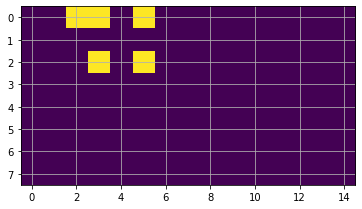

In [74]:
plt.imshow(im1<15)
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
%%time
pores = np.zeros(grid_data["pores"].shape)
pores[canonical_dists_dict[(28,20)][0]["indxs"]] = 1
pores = generate_tubular_paths(pores)*10
pores = pores + (grid_data["distance_grid"] > 1.523)*1
write2vtk(pores, "%s_pores.vtk" % cif)